In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import cartopy 
import numpy as np
import xarray as xr
import math as m
from datetime import datetime
from datetime import timedelta
from glob import glob
from parcels import (grid, Field, FieldSet, SummedField, VectorField, ParticleSet, JITParticle, ScipyParticle, AdvectionRK4, ErrorCode, ParticleFile, Variable, plotTrajectoriesFile)



path_dataSMOC = '/data/oceanparcels/input_data/CMEMS/GLOBAL_ANALYSIS_FORECAST_PHY_001_024_SMOC/'

#### FIELDSET SMOC #####
def choosefield(whichfield):
    if whichfield=='hourly':
        SMOCfiles = path_dataSMOC+'SMOC_202003*.nc'
    elif whichfield== 'mean':
        SMOCfiles = '/scratch/tycho/SMOC*2020.nc'
    else:
        raise ValueError('wrong field')
    filenames_SMOC = {'U': SMOCfiles,
                       'V': SMOCfiles}
    variables_SMOC = {'U' : 'uo',
                 'V' : 'vo'}
    dimensions_SMOC = {'U': {'time' : 'time',
                        'lat' : 'latitude',
                        'lon' : 'longitude',
                       'depth': 'depth'},
                  'V': {'time' : 'time',
                        'lat' : 'latitude',
                        'lon' : 'longitude',
                       'depth': 'depth'}}
    indices_SMOC = {'lon' : range(1380, 1620),
               'lat' : range(1620,1740)}
    #mesh = fieldFiles[0]
    filenames_SMOC = {'U': SMOCfiles,
                       'V': SMOCfiles}
    variables_tides = {'U' : 'utide',
                 'V' : 'vtide'}
    dimensions_tides = {'U': {'time' : 'time',
                        'lat' : 'latitude',
                        'lon' : 'longitude',
                       'depth': 'depth'},
                  'V': {'time' : 'time',
                        'lat' : 'latitude',
                        'lon' : 'longitude',
                       'depth': 'depth'}}
    indices_SMOC = {'lon' : range(1380, 1620),
               'lat' : range(1620,1740)}
    if whichfield=='hourly':
        fieldset_ns = FieldSet.from_netcdf(filenames_SMOC, 
                                    variables_SMOC, 
                                    dimensions_SMOC,
                                    indices_SMOC,
                                    allow_time_extrapolation = True,
                                   )
        fieldset_tides = FieldSet.from_netcdf(filenames_SMOC, 
                            variables_tides, 
                            dimensions_tides,
                            indices_SMOC,
                            allow_time_extrapolation = True,
                           )
    elif whichfield=='mean':
        fieldset_ns = FieldSet.from_netcdf(filenames_SMOC, 
                                    variables_SMOC, 
                                    dimensions_SMOC,
                                    allow_time_extrapolation = True,
                                   )
        fieldset_tides = FieldSet.from_netcdf(filenames_SMOC, 
                            variables_tides, 
                            dimensions_tides,
                            allow_time_extrapolation = True,
                           )
    fieldset= FieldSet(U=fieldset_ns.U+fieldset_tides.U, V=fieldset_ns.V+fieldset_tides.V)
    return fieldset


def aging(particle, fieldset,time):
    particle.Age+=particle.dt
    if particle.Age>3600*24*15:
        particle.delete()


def deleteparticle(particle,fieldset,time):
    """ This function deletes particles as they exit the domain and prints a message about their attributes at that moment
    """
    particle.delete()
    
    
def SampleVel(particle, fieldset, time):
    particle.u = fieldset.U[time, particle.depth, particle.lat, particle.lon]
    particle.v = fieldset.V[time, particle.depth, particle.lat, particle.lon]
            

 


##### PARTICLE SET ####
npar = 10
class BuoyParticle(JITParticle):
    Age=Variable('Age',initial=0)
    u = Variable('u', initial=0)
    v = Variable('v', initial=0)
    
lon = np.linspace(-65,-45,npar)
lat=np.linspace(55,65,npar)
LON, LAT = np.meshgrid(lon,lat)
times = np.full(np.shape(LON),np.datetime64('2020-03-02'))
depths = np.full_like(LON, 0.494025)


##SMOC
fieldset=choosefield('hourly')
pset = ParticleSet.from_list(fieldset=fieldset,   # the fields on which the particles are advected
                             pclass=BuoyParticle,  # the type of particles (JITParticle or ScipyParticle)
                             lon=LON, # a vector of release longitudes 
                             lat=LAT,    # a vector of release latitudes
                              time=times,
                            depth=depths,
                            repeatdt = timedelta(hours=12))

age_kernel = pset.Kernel(aging)
sample_kernel = pset.Kernel(SampleVel)    # Casting the SampleVel function to a kernel.

#Execute  the kernel and write to file
output_file = pset.ParticleFile(name="/scratch/tycho/diff_model_WT.nc") # the file name and the time step of the outputs
pset.execute(AdvectionRK4+age_kernel+sample_kernel,                 # the kernel (which defines how particles move)
             runtime=3600*24*15,    # the total length of the run
             dt=600,      # the timestep of the kernel
             recovery= {ErrorCode.ErrorOutOfBounds:deleteparticle}, #delete particle when it gets out of the domain
             output_file=output_file)
pset.repeatdt = None
#Execute  the kernel and write to file
output_file = pset.ParticleFile(name="/scratch/tycho/diff_model_WT.nc") # the file name and the time step of the outputs
pset.execute(AdvectionRK4+age_kernel+sample_kernel,                 # the kernel (which defines how particles move)
             runtime=3600*24*15,    # the total length of the run
             dt=600,      # the timestep of the kernel
             recovery= {ErrorCode.ErrorOutOfBounds:deleteparticle}, #delete particle when it gets out of the domain
             output_file=output_file)
output_file.close()

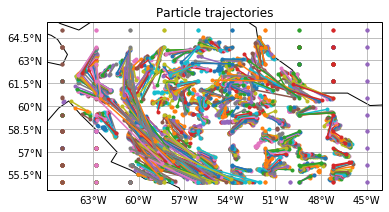

<module 'matplotlib.pyplot' from '/usr/local/lib64/python3.6/site-packages/matplotlib/pyplot.py'>

In [5]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import cartopy 
import numpy as np
import xarray as xr
import math as m
from datetime import datetime
from datetime import timedelta
from glob import glob
from parcels import (grid, Field, FieldSet, SummedField, VectorField, ParticleSet, JITParticle, ScipyParticle, AdvectionRK4, ErrorCode, ParticleFile, Variable, plotTrajectoriesFile)


plotTrajectoriesFile('/scratch/tycho/diff_model_WT.nc')

In [ ]:
##SMOC
fieldset=choosefield('mean')

pset = ParticleSet.from_list(fieldset=fieldset,   # the fields on which the particles are advected
                             pclass=BuoyParticle,  # the type of particles (JITParticle or ScipyParticle)
                             lon=LON, # a vector of release longitudes 
                             lat=LAT,    # a vector of release latitudes
                              time=times,
                            depth=depths)


#Execute  the kernel and write to file
output_file = pset.ParticleFile(name="/scratch/tycho/diff_model_WT_mean.nc") # the file name and the time step of the outputs
pset.execute(AdvectionRK4+age_kernel+sample_kernel,                 # the kernel (which defines how particles move)
             runtime=3600*24*16,    # the total length of the run
             dt=600,      # the timestep of the kernel
             recovery= {ErrorCode.ErrorOutOfBounds:deleteparticle}, #delete particle when it gets out of the domain
             output_file=output_file)
output_file.close()




In [ ]:
output = xr.open_dataset('/scratch/tycho/diff_model_WT.nc')
mean_ds = xr.open_dataset('/scratch/tycho/diff_model_WT_mean.nc')

ITS = 15*24


meanfield = xr.open_dataset('/scratch/tycho/SMOC_monthly_mean_2020.nc')
meanfield['v'] = meanfield.vo + meanfield.vtide
meanfield['u'] = meanfield.uo + meanfield.utide

#Convert to meters/s
output['u']= output.u*1852*60*np.cos(output.lat*np.pi/180)
output['v'] = output.v*1852*60
mean_ds['u']= mean_ds.u*1852*60*np.cos(mean_ds.lat*np.pi/180)
mean_ds['v'] = mean_ds.v*1852*60

D_11 = -((output.u[:,-1]-meanfield.u.isel(depth=0).sel(longitude=output.lon[:,-1], latitude = output.lat[:,-1], time= output.time[:,-1],method='nearest'))
        *((output.lon[:,-1]-output.lon[:,0])*1852*60*np.cos(output.lat[:,-1]*np.pi/180)-
        (mean_ds.lon[:,-1]-mean_ds.lon[:,0])*1852*60*np.cos(output.lat[:,-1]*np.pi/180)))
D_12 = -((output.u[:,-1]-meanfield.u.isel(depth=0).sel(longitude=output.lon[:,-1], latitude = output.lat[:,-1], time= output.time[:,-1],method='nearest'))
        *((output.lat[:,-1]-output.lat[:,0])*1852*60-
        (mean_ds.lat[:,-1]-mean_ds.lat[:,0])*1852*60))
D_21 = -((output.v[:,-1]-meanfield.v.isel(depth=0).sel(longitude=output.lon[:,-1], latitude = output.lat[:,-1], time= output.time[:,-1],method='nearest'))
        *((output.lon[:,-1]-output.lon[:,0])*1852*60*np.cos(output.lat[:,-1]*np.pi/180)-
        (mean_ds.lon[:,-1]-mean_ds.lon[:,0])*1852*60*np.cos(output.lat[:,-1]*np.pi/180)))
D_22 = -((output.v[:,-1]-meanfield.v.isel(depth=0).sel(longitude=output.lon[:,-1], latitude = output.lat[:,-1], time= output.time[:,-1],method='nearest'))
        *((output.lat[:,-1]-output.lat[:,0])*1852*60-
        (mean_ds.lat[:,-1]-mean_ds.lat[:,0])*1852*60))

# D_11 = np.ravel(D_11)
# D_12 = np.ravel(D_12)
# D_21 = np.ravel(D_21)
# D_22 = np.ravel(D_22)





In [ ]:
from binned_statistic2 import binned_statistic_2d_new
Nbin = 20
D_11_bin,  xedges, yedges,binnumber_davis = binned_statistic_2d_new(output.lon[:,-1],\
                output.lat[:,-1],D_11.astype('float'), statistic='nanmean',range=([-65,-45],[55,65]),bins=Nbin)
D_12_bin,  xedges, yedges, binnumber_davis = binned_statistic_2d_new(output.lon[:,-1],\
                output.lat[:,-1], D_12.astype('float'), statistic='nanmean',range=([-65,-45],[55,65]),bins=Nbin, expand_binnumbers=True)
D_21_bin,  xedges, yedges, binnumber_davis = binned_statistic_2d_new(output.lon[:,-1],\
                output.lat[:,-1], D_21.astype('float'), statistic='nanmean',range=([-65,-45],[55,65]),bins=Nbin, expand_binnumbers=True)
D_22_bin,  xedges, yedges, binnumber_davis = binned_statistic_2d_new(np.ravel(output.lon[:,-1]),\
                output.lat[:,-1], D_22.astype('float'), statistic='nanmean',range=([-65,-45],[55,65]),bins=Nbin, expand_binnumbers=True)
counts,  xedges, yedges, binnumber_davis = binned_statistic_2d_new(output.lon[:,-1],\
                output.lat[:,-1],D_11.astype('float'), statistic='count',bins=Nbin, range=([-65,-45],[55,65]), expand_binnumbers=True)

from scipy import linalg

D_11_bin=np.swapaxes(D_11_bin, 0, 1)
D_12_bin=np.swapaxes(D_12_bin, 0, 1)
D_21_bin=np.swapaxes(D_21_bin, 0, 1)
D_22_bin=np.swapaxes(D_22_bin, 0, 1)
counts=np.swapaxes(counts, 0, 1)

#Define grid
lon=np.linspace(-64.5, -45.5, Nbin)
lat = np.linspace(55.25, 64.25, Nbin)
lon, lat = np.meshgrid(lon, lat)

x = np.linspace(-64.5, -45.5,Nbin)
y = np.linspace(55.25, 64.75,Nbin)
X, Y = np.meshgrid(x, y)

    #%% Add the diffusivity components to 1 xarray dataset
k_matrix =xr.Dataset({'k11':(['x','y'],D_11_bin),
                      'k12':(['x','y'],D_12_bin),
                      'k21':(['x','y'],D_21_bin),
                      'k22':(['x','y'],D_22_bin)},                     
                  coords={
                "lon": (["x","y"],lon),
                  "lat": (["x","y"],lat)},)

#Symmetric part:
k_S =xr.Dataset({'k11':(['lat','lon'],D_11_bin),
                      'k12':(['lat','lon'],(D_12_bin+D_21_bin)/2),
                      'k21':(['lat','lon'],(D_21_bin+D_12_bin)/2),
                      'k22':(['lat','lon'],D_22_bin)},                     
                  coords={
                "lon": (["lon"],x),
                  "lat": (["lat"],y)},)

#Same for the number of counts per grid cell
counts_xr =xr.Dataset({'counts':(['x','y'],counts)},                     
                  coords={
                "lon": (["x","y"],lon),
                  "lat": (["x","y"],lat)},)
# Filter out grid cells with less then 50 data points
# for i in range(Nbin):
#     for j in range(Nbin):
#         if counts_xr.counts[i,j]<20:
#             k_S.k11[i,j] = np.nan
#             k_S.k12[i,j] = np.nan
#             k_S.k21[i,j] = np.nan
#             k_S.k22[i,j] = np.nan
#%%




#%%
#Create arrays for eigen values and eigenvectors:
eig_val = np.zeros((len(lat),len(lon),2))
eig_vec = np.zeros((len(lat),len(lon),2,2))

#Calculate the eigenvalues and eigenvectors for every bin:
for i in range(Nbin):
    for j in range(Nbin):
        try:
            eig_val[i,j,:], eig_vec[i,j,:,:] = linalg.eig(k_S.isel(lat=i,lon=j).\
                to_array().values.reshape(2,2),check_finite=True)
        except (ValueError): #If there are nan values in the diffusivity: fill eigenvalue and eigenvectors with nans
            eig_val[i,j,:]=[np.nan, np.nan]
            eig_vec[i,j,:,:]=([np.nan, np.nan],[np.nan, np.nan])
            continue


#Make an xarray dataset of the eigenvalues and eigenvectors:
eig_val =xr.Dataset({'labda':(['lat','lon','i'],eig_val)},
                  coords={
                "lon": (["lon"],x),
                  "lat": (["lat"],y)},)
eig_vec =xr.Dataset({'mu':(['lat','lon','i','j'],eig_vec)},
                  coords={
                "lon": (["lon"],x),
                  "lat": (["lat"],y)},
                  attrs={
                      "title": 'Eigen vectors per grid cell'})



eig_val.to_netcdf('/scratch/tycho/eig_val_WT.nc')
eig_vec.to_netcdf('/scratch/tycho/eig_vec_WT.nc')




In [ ]:

import pandas as pd
import matplotlib.pyplot as plt
import cartopy 
import numpy as np
import xarray as xr
import math as m
from datetime import datetime
from datetime import timedelta
from glob import glob
from parcels import (grid, Field, FieldSet, SummedField, VectorField, ParticleSet, JITParticle, ScipyParticle, AdvectionRK4, ErrorCode, ParticleFile, Variable, plotTrajectoriesFile)



output = xr.open_dataset('/scratch/tycho/diff_model_WT.nc')
mean_ds = xr.open_dataset('/scratch/tycho/diff_model_WT_mean.nc')
eig_val = xr.open_dataset('/scratch/tycho/eig_val_WT.nc')
eig_vec= xr.open_dataset('/scratch/tycho/eig_vec_WT.nc')

In [ ]:
mean_ds

In [ ]:
%matplotlib notebook


from plotting_functions import plot_ellipse
plot_ellipse(eig_val, eig_vec)

In [ ]:
output

In [ ]:
smoc_test = xr.open_mfdataset(path_dataSMOC+'SMOC_202003*',combine='by_coords')

In [ ]:
smoc_test

In [ ]:
output = xr.open_dataset('/scratch/tycho/diff_model_NT.nc')

np.nanmin(output.Age.values)
